# Exploring the critical community size of an SIR model

The critical community size (CCS) refers to the minimum population size required for an infectious disease to persist in a community without going extinct due to random fluctuations.  It would be more accurate to refer to the critical birth cohort, since the key factor is really not the total population but the rate of influx of new susceptibles - however, CCS is the more commonly used term in the field, and we will follow that.  
As shown in [notebook 5](https://github.com/laser-base/laser-generic/blob/f58d3d8a9dfc213551c8a8b5b7c1ef764d5bebbd/notebooks/05_SIR_wbirths_age_distribution.ipynb) on the equilibrium age distribution, the SIR system has an endemic equilibrium solution

$$
(S^*, \: I^*, \: R^*) = N*(\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\
$$

and [notebook 6](https://github.com/laser-base/laser-generic/blob/50796ab5a253df168255e8a3ac54b766f6aa55d5/notebooks/06_SIR_wbirths_natural_periodicity.ipynb), illustrates the stochastic fluctuations in the infectious population around this equilibrium.  It stands to reason, then, the smaller the the equilibrium infected population $\frac{N \mu (R_0-1)}{\beta}$ (or more precisely, the larger the amplitude of fluctuations relative to $ I^* $), the more probable it becomes that the infected population will randomly fluctuate to 0.  In considering spatial patch models of disease transmission, this is a critical behavior that differentiates the disease dynamics of continuous vs. discrete models, and of spatially structured models with many small populations from unstructured models of large populations.  Modeling the spatial population and connectivity structure is thus essential for understanding how local extinctions and reintroductions shape disease persistence at larger scales.

While the intuition makes sense, there's not a single, shared mathematically precise definition of the critical community size - how probable does a stochastic extinction need to be, within how long of a time window, to draw a dividing line between above and below the CCS?  Different authors have taken different approaches to defining CCS and analyzing the system and found slightly different approximations to the CCS.  In Nasell, Theoretical Population Biology 67 (2005) 203–216, we find three formulae (the third credited to Diekmann & Heesterbeek, Mathematical Epidemiology
of Infectious Diseases (2000)):

$$
N_{crit,1} = \frac{2 \pi}{log(2)} \frac{\alpha^\frac{3}{2} R_0}{(R_0-1)^\frac{3}{2}} \\
\\
N_{crit,2} = \frac{K \alpha^2 R_0}{R_0-1} \\ 
\\ 
N_{crit,3} = \frac{\alpha^2 R_0^2}{(R_0-1)^2}\\
$$
where $\alpha = \frac{\gamma + \mu}{\mu}$, and $K$ represents a chosen time horizon in units of $\mu$.  There are slight differences in functional form between these, but what they share in common provides some good intuiation.  First, a strong dependence on the ratio of $\gamma$ to $\mu$ - that is, how long is the infectious period relative to the timescale of susceptible replenishment.  Second, relatively weak dependence on $R_0$ as long as it's reasonably larger than 1.  One might expect $R_0$ to play a large role here, but in fact all diseases seek $R_{eff} \approx 1$ near the endemic equilibrium, and so the impact of $R_0$ on pathogen survival is weak unless $R_0$ is quite small.


In this notebook, we will demonstrate ability to reproduce the CCS phenomenon, and fit CCS against the $\alpha$ & $R_0$ parameters to see which, if any, of the above formula we reproduce.  To do this, we will construct the first patch model in this series of notebooks, setting up each simulation with a set of patches covering a couple orders of magnitude in population size from the smallest to the largest.  As the concept of CCS is defined for a population, we will not yet connect these population patches to each other (that will come in the next notebooks), but will let the disease dynamics play out independently in each to see where the disease persists and where it self-extinguishes.

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SIR
from laser.generic import Model
from laser.generic.utils import ValuesMap
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.utils import grid
import laser.core
import laser.generic
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.8.0'
laser.generic.__version__='0.0.0'


In [2]:
class Importation_EachNode:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3, duration: int = 20*365):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count
        self.duration = duration

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0 and tick < self.duration:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            n_susceptible = self.model.people.nodeid[i_susceptible]
            for node in np.unique(self.model.people.nodeid):
                these_susceptibles = i_susceptible[n_susceptible==node]
                if len(these_susceptibles) > 0:
                    count = min(self.count, len(these_susceptibles))
                    i_infect = np.random.choice(these_susceptibles, size=count, replace=False)
                    self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                    samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                    samples = np.round(samples)
                    samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                    self.model.people.itimer[i_infect] = samples
                    self.model.nodes.S[tick + 1, node] -= count
                    self.model.nodes.I[tick + 1, node] += count
                    self.model.nodes.imports[tick, node] = count
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

# _Important_

Note that running the 200 simulations below takes a few hours even on modern hardware.

We have set `run_sims` to False by default. Change `run_sims` to True to (re)generate the results.


In [11]:
run_sims = False
analyze_sims = True

In [ ]:
npatches = 61
scenario = grid(M=1, N=npatches, population_fn=lambda x,y: np.ceil(10**(3 + y*(3/(npatches-1)))).astype(np.uint32), origin_x=0, origin_y=0)
initial_infected = 3
nticks = 40 * 365
nsims = 200
i = 0
start_from_last = False
outputs = None

if run_sims:

    i = 0

    if start_from_last:  #If we are resuming from a stopped previous run

        outputs =np.load(os.path.join("outputs", "CCS_outputs.npy"))
        while i < outputs.shape[0] and np.any(outputs[i]):
            i += 1
        R0_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[0, :]
        infmean_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[1, :]
        cbr_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))[2, :]

    else:
        
        R0_samples = np.random.uniform(1.05, 2.5, nsims)**3
        infmean_samples = 5 + np.random.gamma(2, 10, nsims)
        cbr_samples = 10 + np.random.gamma(2, 20, nsims)
        cbr_samples = np.clip(cbr_samples, 10, 100)
        np.save(os.path.join("outputs", "CCS_parameter_samples.npy"), np.vstack([R0_samples, infmean_samples, cbr_samples]))
        outputs = np.zeros((nsims, nticks+1, npatches), dtype=np.uint32)
    
    while i < nsims:

        R0 = R0_samples[i]
        infmean = infmean_samples[i]
        cbr = cbr_samples[i]
        print(f"Running simulation {i+1}/{nsims} with R0={R0:.2f}, infmean={infmean:.2f}, cbr={cbr:.2f}")

        scenario["I"] = initial_infected
        scenario["R"] = np.floor(scenario.population * (R0-1)/ R0).astype(np.uint32)
        scenario["S"] = scenario.population - scenario["I"] - scenario["R"]

        parameters = PropertySet(
            {
                "seed": np.random.randint(0, 1000000),
                "nticks": nticks,
                "verbose": True,
                "beta": R0 / infmean,
                "inf_mean": infmean,
                "cbr": cbr,
                "importation_period": 180,
                "importation_count": 3,
                "importation_end": 20 * 365,
            }
        )

        birthrate_map = ValuesMap.from_scalar(parameters.cbr, nticks=parameters.nticks, nnodes=len(scenario))
        infdurdist = dists.exponential(scale=parameters.inf_mean)
        rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
        stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
        pyramid = AliasedDistribution(stable_age_dist)
        survival = KaplanMeierEstimator(stable_age_dist.cumsum())
        model = Model(scenario, parameters, birthrates=birthrate_map.values)
        model.network = 0*model.network
        model.components = [
            SIR.Susceptible(model),
            SIR.Recovered(model),
            SIR.Infectious(model, infdurdist),
            Importation_EachNode(model, infdurdist, period=parameters.importation_period, count=parameters.importation_count, duration=parameters.importation_end),
            SIR.Transmission(model, infdurdist),
            BirthsByCBR(model, birthrate_map.values, pyramid),
            MortalityByEstimator(model, estimator=survival),        
        ]
        model.run()
        outputs[i, :, :] = model.nodes.I
        os.makedirs("outputs", exist_ok=True)
        np.save(os.path.join("outputs", "CCS_outputs.npy"), outputs)
        i+=1


/var/folders/fl/_ns4br_j2qxd92vjrgl3t4n00000gn/T/ipykernel_69058/2173563150.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(outputs[0, :, :].T / pops[:, np.newaxis]), aspect="auto", origin="lower")


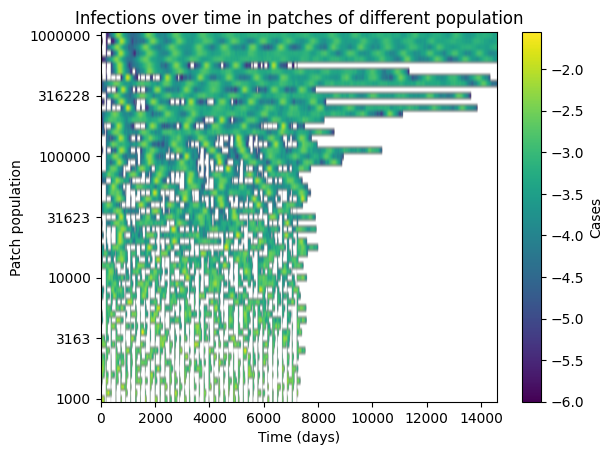

In [13]:
if analyze_sims:

    outputs = np.load(os.path.join("outputs", "CCS_outputs.npy"))
    parameter_samples = np.load(os.path.join("outputs", "CCS_parameter_samples.npy"))
    R0_samples = parameter_samples[0, :]
    infmean_samples = parameter_samples[1, :]
    cbr_samples = parameter_samples[2, :]
    params_df = pd.DataFrame({
        "R0": R0_samples,
        "infmean": infmean_samples,
        "cbr": cbr_samples,
    })
    params_df['mu'] = (1 + params_df['cbr'] / 1000) ** (1 / 365) - 1
    params_df['alpha'] = (1 / params_df['infmean'] + params_df['mu'])/params_df['mu']
    nsims, nticks, npatches = outputs.shape

    pops = np.array(scenario.population)
    plt.imshow(np.log10(outputs[0, :, :].T / pops[:, np.newaxis]), aspect="auto", origin="lower")
    plt.colorbar(label="Cases")
    plt.xlabel("Time (days)")
    plt.ylabel("Patch population")
    plt.yticks(range(0, npatches, 10), pops[::10])
    plt.title("Infections over time in patches of different population")
    plt.show()


### Estimating the CCS

We will analyze two possible definitions for the CCS from our simulation outputs - the smallest population in which the disease persists through the end of simulation, and the largest population in which the disease fails to persist.   We will opt for the former definition as being more consistent with the definition - stochastic extinctions certianly can happen in above-CCS populations in a given sim, due to oscillations, relative timing of when we turn off new importations, etc.  Alternatively, we should never see disease persistence in sub-CCS populations, and so we will define our empirical estimate of the CCS to be (at most) the smallest population in which we do observe persistence.

In [14]:
if outputs is not None:

    CCS_est = []

    for sim in range(nsims):
        end_output = outputs[sim, -1, :]
        nonzero_pops = pops[end_output != 0]
        if len(nonzero_pops) > 0:
            CCS_est.append(np.min(nonzero_pops))
        else:
            CCS_est.append(np.max(pops))

    results_df = pd.DataFrame({"CCS_est": CCS_est})

    print(results_df)

else:
    results_df = None
    print("No simulation outputs found for analysis.")

     CCS_est
0     398108
1      14126
2     112202
3      35482
4      63096
..       ...
195  1000000
196  1000000
197  1000000
198  1000000
199  1000000

[200 rows x 1 columns]


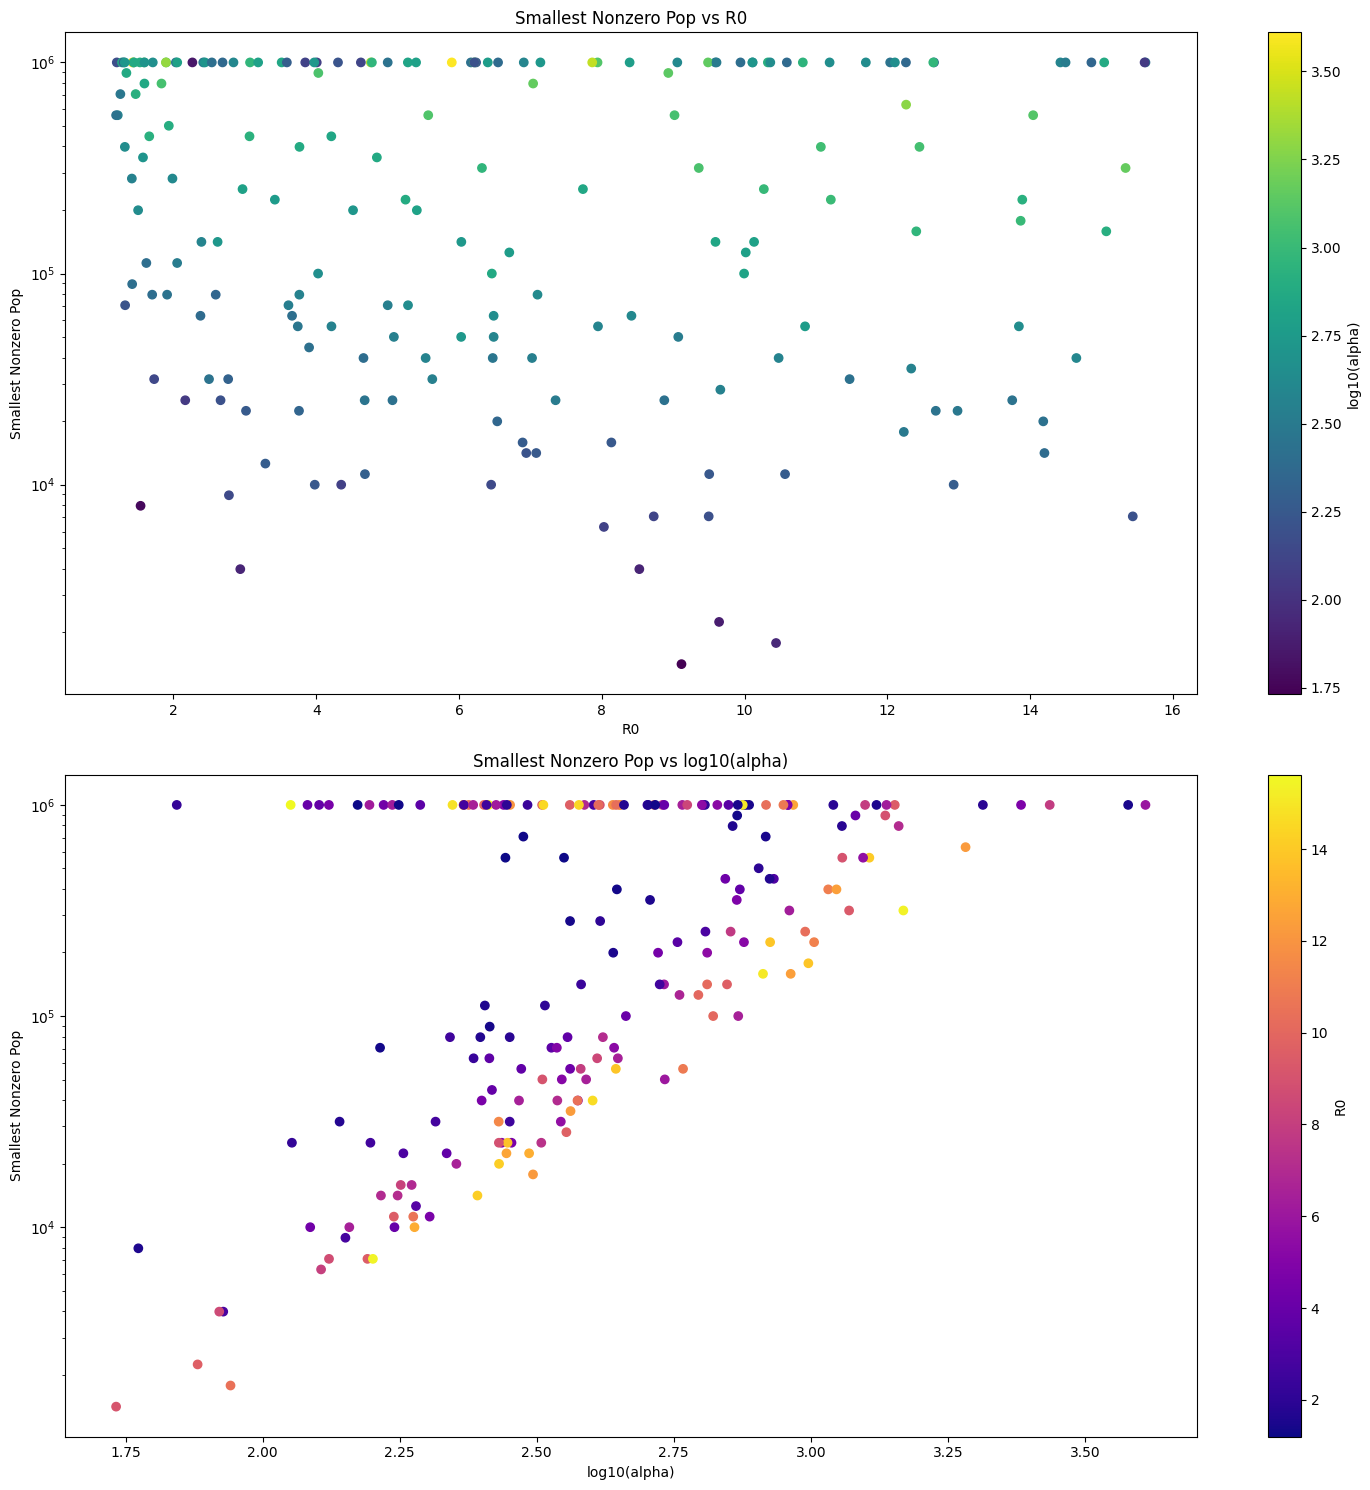

In [15]:
if results_df is not None:

    fig, axs = plt.subplots(2, 1, figsize=(15, 15))

    # Plot smallest_nonzero_pop against R0, colored by log10(alpha)
    sc3 = axs[0].scatter(params_df["R0"], results_df["CCS_est"], c=np.log10(params_df["alpha"]), cmap="viridis")
    axs[0].set_xlabel("R0")
    cbar1 = fig.colorbar(sc3, ax=axs[0])
    cbar1.set_label("log10(alpha)")
    axs[0].set_ylabel("Smallest Nonzero Pop")
    axs[0].set_title("Smallest Nonzero Pop vs R0")
    axs[0].set_yscale("log")

    # Plot smallest_nonzero_pop against log10(alpha), colored by R0
    sc4 = axs[1].scatter(np.log10(params_df["alpha"]), results_df["CCS_est"], c=params_df["R0"], cmap="plasma")
    axs[1].set_xlabel("log10(alpha)")
    cbar2 = fig.colorbar(sc4, ax=axs[1])
    cbar2.set_label("R0")
    axs[1].set_ylabel("Smallest Nonzero Pop")
    axs[1].set_title("Smallest Nonzero Pop vs log10(alpha)")
    axs[1].set_yscale("log")


    plt.tight_layout()
    plt.show()

else:
    print("No results to plot.")


OK, now we are going to start some fitting, to see whether our simulations reproduce something like the functional dependences above.

We are going to run into a bit of an inference power issue w/r/t dependence on the term of the form $\frac{R_0}{R0-1}$ - we are fitting a quantity (CCS) varying over orders of magnitude, with one parameter ($\alpha$) also varying over orders of magnitude, but this ratio being for the most part close to 1.  So we'll go ahead and assume one exponent for the ratio $\frac{R_0}{R0-1}$ for now, and simply see whether we recover something like the expected functional dependence.  

In [16]:
from scipy.optimize import curve_fit

# Define the fitting function for curve_fit
def fitting_function(X, constant, a, b):
    alpha, R0 = X
    return constant * alpha**a * (R0/(R0-1))**b

if (results_df is not None) and (params_df is not None):

    # Since we are bounded above and below, filter out the max and min values of CCS_est
    inds2fit = (results_df["CCS_est"] != np.max(pops)) & (results_df["CCS_est"] != np.min(pops))

    # Prepare the data for multivariate fitting
    # Remove rows with NA in smallest_nonzero_pop
    alpha_values = params_df["alpha"][inds2fit].values
    R0_values = params_df["R0"][inds2fit].values
    CCS_est_values = results_df["CCS_est"][inds2fit].values

    # Stack alpha and R0 as input for curve_fit
    Xdata = np.vstack((alpha_values, R0_values))
    # Fit the function to the data
    popt, pcov = curve_fit(
        fitting_function,
        Xdata,
        CCS_est_values,
        bounds=([0.1, -2.5, -2.5], [100, 2.5, 2.5]),
        maxfev=10000
    )

    # # Extract the optimal parameters
    # constant_opt, a_opt, b_opt, c_opt = popt
    print(f"Optimal parameters:  constant = {popt[0]}, a = {popt[1]}, b = {popt[2]}")#, c = {popt[3]}")
    print(f"Covariance matrix:\n{pcov}")

else:

    alpha_values = None
    R0_values = None
    CCS_est_values = None

    print("No results available for curve fitting.")

Optimal parameters:  constant = 13.40964606641732, a = 1.4422785083295673, b = 1.2081049473111136
Covariance matrix:
[[ 5.63355597e+01 -5.86606156e-01 -3.54314444e-01]
 [-5.86606156e-01  6.15055949e-03  3.44003397e-03]
 [-3.54314444e-01  3.44003397e-03  4.91230329e-03]]


Looks pretty good - critically, we recover a dependence close to $\alpha^{3/2}$, matching one of the derived formulas above.  We also get a constant of order 1-10 (2 of the 3 formulas had a constant in this range).  Finally, we fit close to squared dependence on the ratio $\frac{R_0}{R_0-1}$ (this doesn't exactly match the formula with $\alpha^{3/2}$ dependence from the begining, but again we have very little no power on this term, as evidenced by the relatively large covariance on it).  Overall, reasonable fits here.

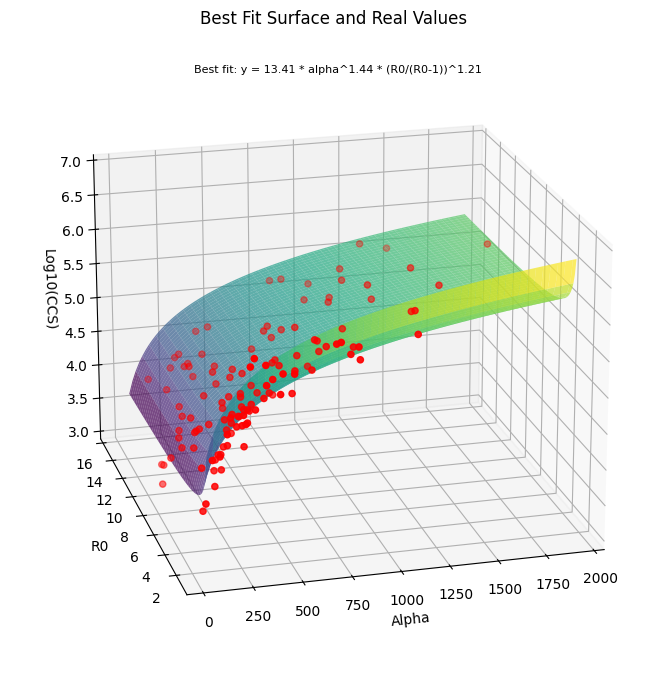

In [17]:
if (alpha_values is not None) and (R0_values is not None) and (CCS_est_values is not None):

    # # Create a meshgrid for alpha and R0 values
    alpha_fit = np.linspace(min(alpha_values), max(alpha_values), 100)
    R0_fit = np.linspace(min(R0_values), max(R0_values), 100)
    alpha_fit, R0_fit = np.meshgrid(alpha_fit, R0_fit)

    # # Calculate the best fit surface
    best_fit_surface = fitting_function((alpha_fit, R0_fit), popt[0], popt[1], popt[2])

    # Plot the best fit surface
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection="3d")


    # # Plot the best fit surface
    ax.plot_surface(alpha_fit, R0_fit, np.log10(best_fit_surface), cmap="viridis", alpha=0.7)

    # # Scatter the real values for comparison
    ax.scatter(alpha_values, R0_values, np.log10(CCS_est_values), color="red", label="Real Values")

    ax.set_xlabel("Alpha")
    ax.set_ylabel("R0")
    ax.set_zlabel("Log10(CCS)")
    ax.set_title("Best Fit Surface and Real Values")

    # # Add the best fit equation as a textbox
    equation_text = f"Best fit: y = {popt[0]:.2f} * alpha^{popt[1]:.2f} * (R0/(R0-1))^{popt[2]:.2f}"
    fig.text(.4, 0.9, equation_text, transform=fig.transFigure, fontsize=8, verticalalignment='top')

    plt.tight_layout()
    # # Rotate the camera for a better viewing angle
    ax.view_init(elev=20, azim=255)
    plt.show()

else:

    print("Insufficient data for 3D plotting.")